In [59]:
from CPT import CPT, read_file, pprint_tree

import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline

In [17]:
YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'
raw = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')
raw = raw.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
## -------------------------------------------------- ##
raw['pitchID'] = np.where(raw['pitchID']=='-1', np.nan, raw['pitchID'])
raw['pitchID'] = raw['pitchID'].ffill()
## -------------------------------------------------- ##
rawdate = pd.DataFrame(raw['pitchID'])
raw['game_date_new'] = rawdate.applymap(str).applymap(lambda s: '20{}-{}-{} {}:{}:{}'.format(s[0:2],s[2:4],s[4:6], s[7:9],s[9:11],s[11:13]))
## -------------------------------------------------- ##
df = raw.copy()
df = df.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
# ## -------------------------------------------------- ##
# df['throws_stands'] = df['throws']+'_'+df['stands']
# df['throws_stands_le']= df['throws_stands'].replace({'우_우':'1', '우_좌':'2', '좌_우':'3', '좌_좌':'4'}, regex=True)

# def one_digit(n): return f"{n:.0f}"
# def two_digit(n): return f"{n:02d}"
# def three_digit(n): return f"{n:03d}"
# def six_digit(n): return f"{n:06d}"
# df['zone101_new']=df['zone101_new'].apply(two_digit)
# df['bs_cnt']=df['bs_cnt'].apply(two_digit)
# df['bso_cnt']=df['bso_cnt'].apply(three_digit)
# df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)

In [42]:
pit_len = df.groupby(['gid-intot-panum']).agg(pit_len=('pitch_number','last')).reset_index()
dfdf = pd.merge(df, pit_len, on='gid-intot-panum', how='left')

cf=dfdf[dfdf['pit_len']>=3][['gid-intot-panum', 'pitch_type', 'pitch_number', 'pit_len']]
cf.to_csv('pitch3_train.csv', encoding='cp949')

In [49]:
def read_file_new(filename, id_col, line_num_col, code_col, require_sorting=False):
    # Read csv file and create list of data
    df = pd.read_csv(filename, sep=",", engine='python', keep_default_na=False, encoding='cp949')
    if require_sorting:
        df = df.sort_values(by=[id_col, line_num_col], ignore_index=True)  # Sorted by Pentaho

    dat = []
    hist_ref = df[id_col][0]
    current_seq = []

    for _, row in df.iterrows():
        if row[id_col] == hist_ref:
            current_seq.append(row[code_col])
        else:
            dat.append(current_seq)
            current_seq = []
            hist_ref = row[id_col]
            current_seq.append(row[code_col])

    return dat

In [50]:
datafile = 'pitch3_train.csv'
%time data = read_file_new(datafile, id_col='gid-intot-panum', line_num_col='pitch_number', code_col='pitch_type', require_sorting=False)

CPU times: total: 53.1 s
Wall time: 53.2 s


In [51]:
print("total nb of sequences %i" % len(data))

total nb of sequences 245368


In [65]:
data[:10]

[['직구', '직구', '직구', '직구', '직구'],
 ['슬라', '슬라', '슬라'],
 ['직구', '커브', '직구', '체인', '직구', '슬라'],
 ['커브', '직구', '직구', '체인', '커브'],
 ['직구', '커브', '직구', '직구', '슬라', '투심', '슬라'],
 ['직구', '직구', '직구'],
 ['직구', '직구', '직구'],
 ['직구', '직구', '직구', '슬라'],
 ['슬라', '직구', '투심', '직구'],
 ['직구', '직구', '직구', '슬라', '체인']]

In [68]:
# Split train and test
sample_size = 500

seq = pd.DataFrame({'seq':data})
test_sample = seq.sample(n=sample_size)
data_test = test_sample['seq'].to_list()
train = seq[~seq.index.isin(test_sample.index)]
data_train = train['seq'].to_list()

In [69]:
# Instantiate Model
my_cpt = CPT()

In [70]:
# Train Model
%time my_cpt.train(data, max_seq_length=10)
my_cpt.prune(2)

CPU times: total: 1.89 s
Wall time: 1.89 s


In [71]:
nb_of_preds = 3
%time result_with_score = my_cpt.predict(data_test, n=nb_of_preds, k=10, p=1, coef=2.5)

CPU times: total: 4min 59s
Wall time: 5min 1s


In [72]:
result = [[k for k,v in pred] for pred in result_with_score]
result_first = [x[0] for x in result]

ndf = pd.DataFrame(data={'Prefix':[l[:-1] for l in data_test],'Real':[l[-1:][0] for l in data_test],'Pred':result_first,'Full_Pred':result,'Full_Pred_Score':result_with_score})

In [73]:
ndf.head()

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,"[투심, 투심, 슬라]",슬라,슬라,"[슬라, 직구, 투심]","[(슬라, nan), (직구, nan), (투심, nan)]"
1,"[커브, 커브, 커브, 포크]",직구,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"
2,"[직구, 직구, 슬라]",슬라,슬라,"[슬라, 직구, 체인]","[(슬라, nan), (직구, nan), (체인, nan)]"
3,"[슬라, 슬라, 직구, 슬라]",슬라,슬라,"[슬라, 직구, 체인]","[(슬라, nan), (직구, nan), (체인, nan)]"
4,"[직구, 직구, 슬라, 슬라]",커브,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"


In [74]:
# % of predictions were the first result is the good one
accuracy = (ndf['Real']==ndf['Pred']).sum()/ndf.shape[0] * 100
print("%.2f %% of good predictions !" % accuracy)

75.60 % of good predictions !


In [75]:
# % of predictions were result is in the n first predictions
ok = []
for idx,row in ndf.iterrows():
#     print(row.Real in row.Full_Pred)
    if row.Real in row.Full_Pred:
        ok.append(idx)
        
accuracy = len(ok)/ndf.shape[0] * 100
print("%.2f %% in the %s first predictions" % (accuracy,nb_of_preds))

100.00 % in the 3 first predictions


In [76]:
# % of predictions with no result
no_answer = (ndf['Pred']=='--NO-RESULT--').sum()/ndf.shape[0] * 100
print("%.2f %%  without answer" % no_answer)

0.00 %  without answer


In [77]:
# example of good predictions
ndf[(ndf['Real']==ndf['Pred'])==True][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,"[투심, 투심, 슬라]",슬라,슬라,"[슬라, 직구, 투심]","[(슬라, nan), (직구, nan), (투심, nan)]"
1,"[커브, 커브, 커브, 포크]",직구,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"
2,"[직구, 직구, 슬라]",슬라,슬라,"[슬라, 직구, 체인]","[(슬라, nan), (직구, nan), (체인, nan)]"
3,"[슬라, 슬라, 직구, 슬라]",슬라,슬라,"[슬라, 직구, 체인]","[(슬라, nan), (직구, nan), (체인, nan)]"
5,"[직구, 직구, 직구, 커브]",직구,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"


In [78]:
# example of bad predictions
ndf[(ndf['Real']==ndf['Pred'])==False][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
4,"[직구, 직구, 슬라, 슬라]",커브,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"
6,"[슬라, 슬라, 직구, 슬라]",커브,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"
8,"[직구, 직구, 슬라, 슬라, 직구, 슬라]",체인,슬라,"[슬라, 체인, 직구]","[(슬라, nan), (체인, nan), (직구, nan)]"
19,"[커브, 커브, 투심]",커브,직구,"[직구, 커브, 체인]","[(직구, nan), (커브, nan), (체인, nan)]"
24,"[투심, 슬라, 슬라, 슬라, 직구, 체인, 체인]",투심,직구,"[직구, 슬라, 투심]","[(직구, nan), (슬라, nan), (투심, nan)]"


In [79]:
def conf_matr_plot(ytest,ypred,threshold=0,normalize=True,show_diag=True,show_alls=False):
    conf_matr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
    
    # Filter rows < threshold * global_total
    n_threshold = threshold * conf_matr.loc['All','All']
    conf_matr = conf_matr.loc[(conf_matr['All']>n_threshold),:]  # keep rows > threshold
    
    # Normalize
    if normalize:
        conf_matr = conf_matr.div(conf_matr['All'],axis=0)  # Normalize matrix vs rowsum
#         conf_matr_norm = conf_matr_filter.div(conf_matr_filter.loc['All','All'],axis=0)  # Normalize matrix vs total
    
    # Remove diagonal elements (good predictions)
    if not show_diag:
        for idx, row in conf_matr.iterrows():  
            row.loc[row.name]=0
    
    # Remove columns <= threshold
    drop_col = []
    for col,seri in conf_matr.iteritems(): 
        if seri[seri.index!='All'].sum()<=threshold:
            drop_col.append(col)
    conf_matr = conf_matr.drop(columns=drop_col)
    
    # Drop totals
    if not show_alls:
        conf_matr = conf_matr.drop(columns='All')  # Drop column 'All' always = 1
        conf_matr = conf_matr[conf_matr.index != "All"]  # Drop Row 'All'
    
    conf_matr = round(conf_matr * 100,1)
    
    return conf_matr

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23616\768315616.py:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col,seri in conf_matr.iteritems():


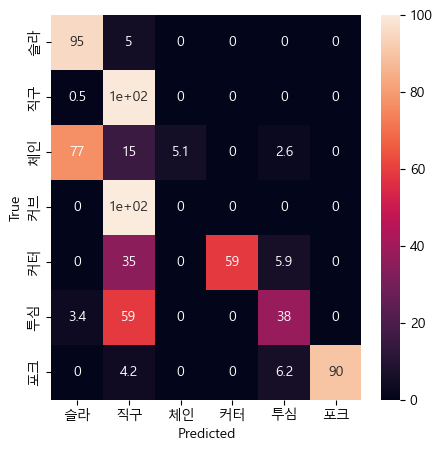

In [83]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.heatmap(conf_matr_plot(ndf['Real'],ndf['Pred'],threshold=0.005,normalize=True,show_diag=True, show_alls=False),annot=True);

In [84]:
# Show Tree
pprint_tree(my_cpt.root_node)

└─ None = 1161904
   ├─ 직구 = 113665
   │  ├─ 직구 = 61528
   │  │  ├─ 직구 = 35597
   │  │  │  ├─ 직구 = 17176
   │  │  │  │  ├─ 직구 = 7358
   │  │  │  │  │  ├─ 직구 = 2566
   │  │  │  │  │  │  ├─ 직구 = 748
   │  │  │  │  │  │  │  ├─ 포크 = 17
   │  │  │  │  │  │  │  │  └─ 직구 = 8
   │  │  │  │  │  │  │  │     └─ 직구 = 4
   │  │  │  │  │  │  │  ├─ 직구 = 199
   │  │  │  │  │  │  │  │  ├─ 커브 = 4
   │  │  │  │  │  │  │  │  ├─ 직구 = 51
   │  │  │  │  │  │  │  │  │  └─ 직구 = 11
   │  │  │  │  │  │  │  │  ├─ 체인 = 4
   │  │  │  │  │  │  │  │  ├─ 슬라 = 11
   │  │  │  │  │  │  │  │  │  └─ 직구 = 2
   │  │  │  │  │  │  │  │  └─ 포크 = 2
   │  │  │  │  │  │  │  ├─ 슬라 = 35
   │  │  │  │  │  │  │  │  └─ 직구 = 10
   │  │  │  │  │  │  │  │     ├─ 커브 = 2
   │  │  │  │  │  │  │  │     └─ 슬라 = 2
   │  │  │  │  │  │  │  ├─ 체인 = 13
   │  │  │  │  │  │  │  │  └─ 체인 = 3
   │  │  │  │  │  │  │  ├─ 커터 = 3
   │  │  │  │  │  │  │  └─ 커브 = 7
   │  │  │  │  │  │  │     └─ 직구 = 2
   │  │  │  │  │  │  ├─ 슬라 = 137
   │  │  │  │  │  │  │  

---
---
# Example

In [34]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from CPT import CPT, read_file, pprint_tree

In [6]:
datafile = 'train.csv'
%time data = read_file(datafile, id_col='ID', line_num_col='LINE_NB', code_col='CODE', require_sorting=False)

CPU times: total: 5.81 s
Wall time: 6.38 s


In [7]:
print("total nb of sequences %i" % len(data))

total nb of sequences 44358


In [8]:
data[:10]

[['UL', 'ULV'],
 ['PX9', 'L5TG', 'L5TG'],
 ['TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP'],
 ['U4', '6ML'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['LYJ', 'LYJ', 'LYJ', 'PX9', 'LYJ', 'GL9L', 'L5TG', 'L5TG'],
 ['3PX', 'V5TG'],
 ['VPX', 'VPX'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['ZZ4', '4LV']]

In [9]:
# Split train and test

sample_size = 500

seq = pd.DataFrame({'seq':data})
test_sample = seq.sample(n=sample_size)
data_test = test_sample['seq'].to_list()
train = seq[~seq.index.isin(test_sample.index)]
data_train = train['seq'].to_list()

In [10]:
# Instantiate Model
my_cpt = CPT()

In [11]:
# Train Model
%time my_cpt.train(data, max_seq_length=10)
my_cpt.prune(2)

CPU times: total: 312 ms
Wall time: 303 ms


In [12]:
# Predict
nb_of_preds = 3
%time result_with_score = my_cpt.predict(data_test, n=nb_of_preds, k=10, p=1, coef=2.5)

CPU times: total: 4.94 s
Wall time: 4.94 s


In [13]:
result = [[k for k,v in pred] for pred in result_with_score]
result_first = [x[0] for x in result]

ndf = pd.DataFrame(data={'Prefix':[l[:-1] for l in data_test],'Real':[l[-1:][0] for l in data_test],'Pred':result_first,'Full_Pred':result,'Full_Pred_Score':result_with_score})

In [14]:
ndf.head()

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[4K],6V,Z8,"[Z8, VZ8, 4EV]","[(Z8, 1.0), (VZ8, 0.0), (4EV, 0.0)]"
1,[95L],95L,L9V,"[L9V, ULV, 95L]","[(L9V, 0.6), (ULV, 0.35), (95L, 0.05)]"
2,"[95L, L9V]",ULV,VPX,"[VPX, L9V, ULV]","[(VPX, 1.0), (L9V, 0.0), (ULV, 0.0)]"
3,[U4],4EV,6ML,"[6ML, ZZ4, U4]","[(6ML, 0.99), (ZZ4, 0.0), (U4, 0.0)]"
4,[VPX],86X,VPX,"[VPX, 86X, Z]","[(VPX, 1.0), (86X, 0.0), (Z, 0.0)]"


In [15]:
# % of predictions were the first result is the good one
accuracy = (ndf['Real']==ndf['Pred']).sum()/ndf.shape[0] * 100
print("%.2f %% of good predictions !" % accuracy)

43.80 % of good predictions !


In [18]:
# % of predictions were result is in the n first predictions

ok = []
for idx,row in ndf.iterrows():
#     print(row.Real in row.Full_Pred)
    if row.Real in row.Full_Pred:
        ok.append(idx)
        
accuracy = len(ok)/ndf.shape[0] * 100
print("%.2f %% in the %s first predictions" % (accuracy,nb_of_preds))

59.20 % in the 3 first predictions


In [19]:
# % of predictions with no result

no_answer = (ndf['Pred']=='--NO-RESULT--').sum()/ndf.shape[0] * 100
print("%.2f %%  without answer" % no_answer)

1.20 %  without answer


In [20]:
# example of good predictions

ndf[(ndf['Real']==ndf['Pred'])==True][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
8,[86X],E6U,E6U,"[E6U, 8QX, 86X]","[(E6U, 1.0), (8QX, 0.0), (86X, 0.0)]"
11,"[JU, JU, JU, JU]",JU,JU,"[JU, J8]","[(JU, 0.91), (J8, 0.09)]"
12,[TK6],TK6,TK6,"[TK6, AG9, A6G]","[(TK6, 0.73), (AG9, 0.14), (A6G, 0.14)]"
14,[UVX],GMJ,GMJ,"[GMJ, UVX, XJ8]","[(GMJ, nan), (UVX, nan), (XJ8, 0.0)]"
15,"[3PX, V5TG]",V5TG,V5TG,"[V5TG, 3PX, VPX]","[(V5TG, 0.54), (3PX, 0.25), (VPX, 0.21)]"


In [21]:
# example of bad predictions

ndf[(ndf['Real']==ndf['Pred'])==False][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[4K],6V,Z8,"[Z8, VZ8, 4EV]","[(Z8, 1.0), (VZ8, 0.0), (4EV, 0.0)]"
1,[95L],95L,L9V,"[L9V, ULV, 95L]","[(L9V, 0.6), (ULV, 0.35), (95L, 0.05)]"
2,"[95L, L9V]",ULV,VPX,"[VPX, L9V, ULV]","[(VPX, 1.0), (L9V, 0.0), (ULV, 0.0)]"
3,[U4],4EV,6ML,"[6ML, ZZ4, U4]","[(6ML, 0.99), (ZZ4, 0.0), (U4, 0.0)]"
4,[VPX],86X,VPX,"[VPX, 86X, Z]","[(VPX, 1.0), (86X, 0.0), (Z, 0.0)]"


In [23]:
def conf_matr_plot(ytest,ypred,threshold=0,normalize=True,show_diag=True,show_alls=False):
    conf_matr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
    
    # Filter rows < threshold * global_total
    n_threshold = threshold * conf_matr.loc['All','All']
    conf_matr = conf_matr.loc[(conf_matr['All']>n_threshold),:]  # keep rows > threshold
    
    # Normalize
    if normalize:
        conf_matr = conf_matr.div(conf_matr['All'],axis=0)  # Normalize matrix vs rowsum
#         conf_matr_norm = conf_matr_filter.div(conf_matr_filter.loc['All','All'],axis=0)  # Normalize matrix vs total
    
    # Remove diagonal elements (good predictions)
    if not show_diag:
        for idx, row in conf_matr.iterrows():  
            row.loc[row.name]=0
    
    # Remove columns <= threshold
    drop_col = []
    for col,seri in conf_matr.iteritems(): 
        if seri[seri.index!='All'].sum()<=threshold:
            drop_col.append(col)
    conf_matr = conf_matr.drop(columns=drop_col)
    
    # Drop totals
    if not show_alls:
        conf_matr = conf_matr.drop(columns='All')  # Drop column 'All' always = 1
        conf_matr = conf_matr[conf_matr.index != "All"]  # Drop Row 'All'
    
    conf_matr = round(conf_matr * 100,1)
    
    return conf_matr

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23616\768315616.py:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col,seri in conf_matr.iteritems():


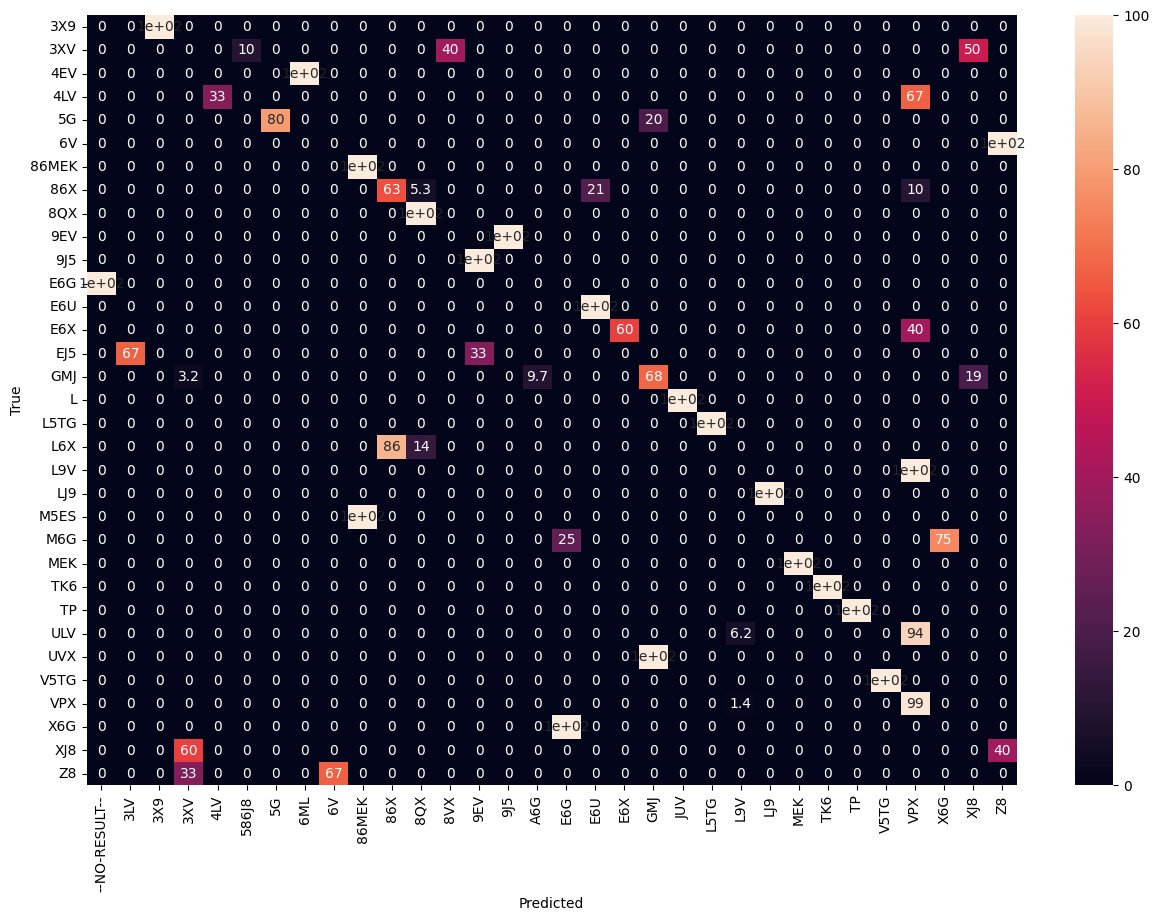

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.heatmap(conf_matr_plot(ndf['Real'],ndf['Pred'],threshold=0.005,normalize=True,show_diag=True, show_alls=False),annot=True);

In [25]:
# Show Tree
pprint_tree(my_cpt.root_node)

└─ None = 129358
   ├─ UL = 7210
   │  ├─ ULV = 1564
   │  │  ├─ L9V = 1439
   │  │  │  ├─ VPX = 115
   │  │  │  ├─ QLV = 5
   │  │  │  ├─ E6X = 7
   │  │  │  ├─ 3LV = 6
   │  │  │  ├─ QPV = 3
   │  │  │  ├─ ELV = 5
   │  │  │  ├─ 5G = 6
   │  │  │  └─ L6X = 2
   │  │  └─ VPX = 6
   │  │     ├─ VPX = 2
   │  │     └─ L9V = 2
   │  ├─ L9V = 4492
   │  │  ├─ ULV = 4376
   │  │  │  ├─ UL = 5
   │  │  │  │  └─ L9V = 5
   │  │  │  │     └─ ULV = 5
   │  │  │  ├─ VPX = 284
   │  │  │  ├─ ELV = 14
   │  │  │  ├─ 3LV = 12
   │  │  │  ├─ E6X = 28
   │  │  │  ├─ L6X = 15
   │  │  │  ├─ QLV = 5
   │  │  │  ├─ QPV = 5
   │  │  │  └─ 86X = 3
   │  │  ├─ 3LV = 2
   │  │  └─ VPX = 12
   │  ├─ 9EV = 444
   │  │  ├─ EJ5 = 176
   │  │  │  └─ 3LV = 4
   │  │  └─ 9J5 = 268
   │  ├─ ELV = 10
   │  │  └─ L9V = 2
   │  │     └─ ULV = 2
   │  ├─ 9J5 = 281
   │  │  └─ 9EV = 195
   │  ├─ EJ5 = 190
   │  │  └─ 9EV = 89
   │  │     └─ QLV = 2
   │  ├─ VPX = 143
   │  │  ├─ L9V = 12
   │  │  │  └─ ULV = 12
   │  │